# Gaussian Process Regression

## Toy Example of Gaussian Process Regression

As a first step, we want to study the Gaussian Process Regression with a toy example as presented in https://www.geeksforgeeks.org/gaussian-process-regression-gpr/.

X Test:  (40, 1) 
Y Test:  (40,) 
X Train:  (40, 1) 
Y Train:  (40,)
Predictions:  (40,) 
Sigma:  (40,)
X:  (1000, 1)
Mean:  (1000,) 
Covariance:  (1000, 1000)


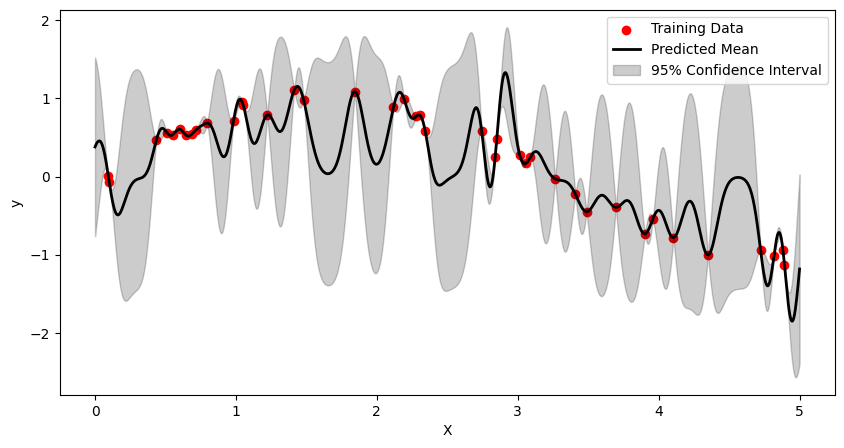

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# Generate sample data
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to the data
y += 0.1 * np.random.randn(80)

# Define the kernel (RBF kernel)
kernel = 1.0 * RBF(length_scale=1.0)

# Create a Gaussian Process Regressor with the defined kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)
print("X Test: ", X_test.shape, "\nY Test: ", y_test.shape, "\nX Train: ", X_train.shape, "\nY Train: ", y_train.shape)

# Fit the Gaussian Process model to the training data
gp.fit(X_train, y_train)

# Make predictions on the test data
y_pred, sigma = gp.predict(X_test, return_std=True)
print("Predictions: ", y_pred.shape, "\nSigma: ", sigma.shape)

# Visualize the results
x = np.linspace(0, 5, 1000)[:, np.newaxis]
print("X: ", x.shape)
y_mean, y_cov = gp.predict(x, return_cov=True)
print("Mean: ", y_mean.shape, "\nCovariance: ", y_cov.shape)

plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, c='r', label='Training Data')
plt.plot(x, y_mean, 'k', lw=2, zorder=9, label='Predicted Mean')
plt.fill_between(x[:, 0], y_mean - 1.96 * np.sqrt(np.diag(y_cov)), y_mean + 1.96 *
                 np.sqrt(np.diag(y_cov)), alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Gaussian Random Field GPR

Now we want to apply the same principle on our Gaussian Random Field. We will generate a Gaussian Random Field with DFT as proposed in the lecture notes and use randomly chosen observations from it for our GPR later.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import ipywidgets as widgets  # only needed for isosurfaces, comment out if you don't have it installed
#import ipyvolume as ipv # only needed for isosurfaces, comment out if you don't have it installed
%matplotlib inline
np.seterr(all='ignore')
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, DotProduct as DP, Matern
from sklearn.gaussian_process.kernels import Kernel, GenericKernelMixin, StationaryKernelMixin, NormalizedKernelMixin
from scipy.special import gamma
from scipy.spatial.distance import cdist, pdist, squareform

First, we generate a GRF with Fourier Transform.

In [3]:
def dft_GRF(n_cells=16, alpha=4, box_size=1.0):
    N = n_cells                          # we discretize our volume using N**3 cells
    L = box_size                          # the box size, sets the fundamental mode

    # create a Gaussian random field of size N**3
    delta0 = np.random.normal(size=[N,N,N])

    kmin = 2.0*np.pi/L # the fundamental mode of the box
    kmax = kmin * N/2     # the Nyquist mode of each linear dimension
    k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
    kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
    kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

    # now 'kv' is the k vector, and 'kmod' its modulus at every point
     
    # Generate GRF with DFT

    norm  = 1.0/(2.0*np.pi)**(-1.5)
    # the matter power spectrum is the product of primordial spectrum and T**2
    def P(k):
        return k**(-alpha)*norm
    
    # generate a complex random field
    fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
    fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
    fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

    # compute (Fast) Fourier Transform of fk
    f = np.real(np.fft.ifftn(fk))

    # re-normalise (should be done using filtered variance)
    f = f / np.std(f.flatten())

    return f

Now we will sample some observations from the generated field.

In [4]:
def get_observations(grf, n_obs=100, n_cells=16, dim=3):
    N = n_cells

    # Observations (example random points in a 3D space)
    X_train = np.random.randint(0, N, size=(n_obs, dim))
    y_train = [grf[x[0],x[1],x[2]] for x in X_train]

    return X_train, y_train

Here, we can perform a Gaussian process regression to get a new field from our observations and given covariance.

In [16]:
def GRF_GPR(X_train, y_train, n_cells=16, dim=3, alpha=4): 
    
    N = n_cells   

    # Points where we want to sample (a grid in a 3D space): array of shape (n_obs, n_features=3)
    X = np.mgrid[0:N, 0:N, 0:N]
    X_test = np.column_stack([X[i].ravel() for i in range(3)])

    constant_value = abs(1/(dim - alpha) * np.pi**(alpha-dim/2) * gamma((dim-alpha)/2) / gamma(alpha/2)) ** (1/(alpha-dim)) 
    beta = abs(dim - alpha) / 2

    print(f"Alpha: {alpha}, Constant Value: {constant_value}, Beta: {beta}")

    kernel = RQ(length_scale=constant_value, alpha=beta)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    mu_s, cov_s = gp.predict(X_test, return_cov=True)
    y_GPR = mu_s.reshape(N, N, N)

    return y_GPR

Last but not least, we want to plot the results to compare them.

In [6]:
def plot_results(grf, X_train, y_GPR, alpha, n_obs, n_cells=16, z_axis=0):
    N = n_cells

    vmin = np.min(grf)
    vmax = np.max(grf)

    fig, ax = plt.subplots(3, 2, figsize=[10, 10])
    fig.suptitle(f"Gaussian Random Field (GRF) and Gaussian Process Regression (GPR) for alpha={alpha} and {n_obs} observations", horizontalalignment='center')

    # Plot original GRF
    ax[0,0].imshow(grf[..., z_axis], cmap='twilight', vmin=vmin, vmax=vmax)
    ax[0, 0].set_title(f"Original GRF")
    ax[0,1].hist(f.flatten(), bins=60, density=True)
    ax[0, 1].set_xlim(vmin, vmax)


    # Plot the samples
    obs = np.zeros((N, N, N))
    for x in X_train:
        obs[x[0], x[1], x[2]] = grf[x[0], x[1], x[2]]

    ax[1,0].imshow(obs[..., z_axis], cmap='twilight')
    ax[1, 0].set_title("Observations of GRF")
    obs_hist = obs[..., N//2].flatten()
    obs_hist = obs_hist[obs_hist != 0]
    ax[1,1].hist(obs_hist, bins=60, density=True)
    ax[1, 1].set_xlim(vmin, vmax)

    # Plot GRF produced by the GPR
    ax[2,0].imshow(y_GPR[..., z_axis], cmap='twilight')
    ax[2, 0].set_title("GRF produced by GPR")
    ax[2,1].hist(y_GPR[..., z_axis].flatten(), bins=60, density=True)
    ax[2, 1].set_xlim(vmin, vmax)

    plt.show()

We will fix the following parameters for our analysis.

In [7]:
N = 16
dim = 3
L = 1.0

We want to compare the performance of the GPR for different alphas.

Alpha: 3.5, Constant Value: 11082.989913202055, Beta: 0.25


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


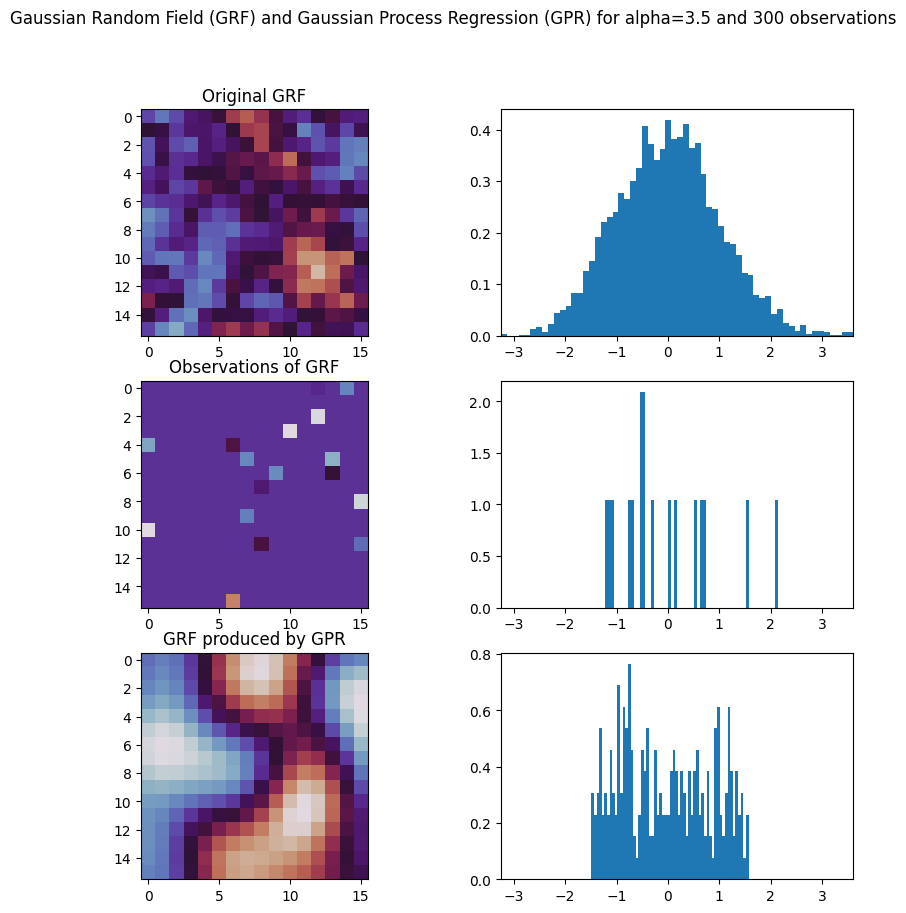

Alpha: 4.5, Constant Value: 19.813660442086075, Beta: 0.75


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


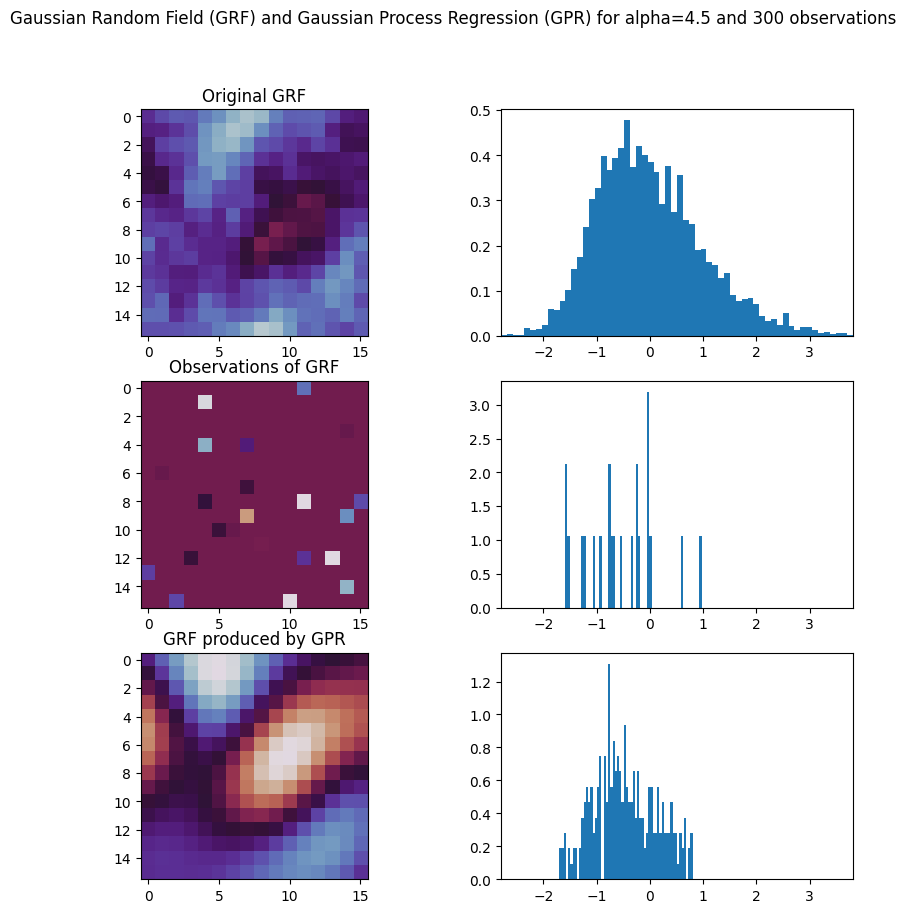

Alpha: 5.5, Constant Value: 6.181360311258466, Beta: 1.25


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


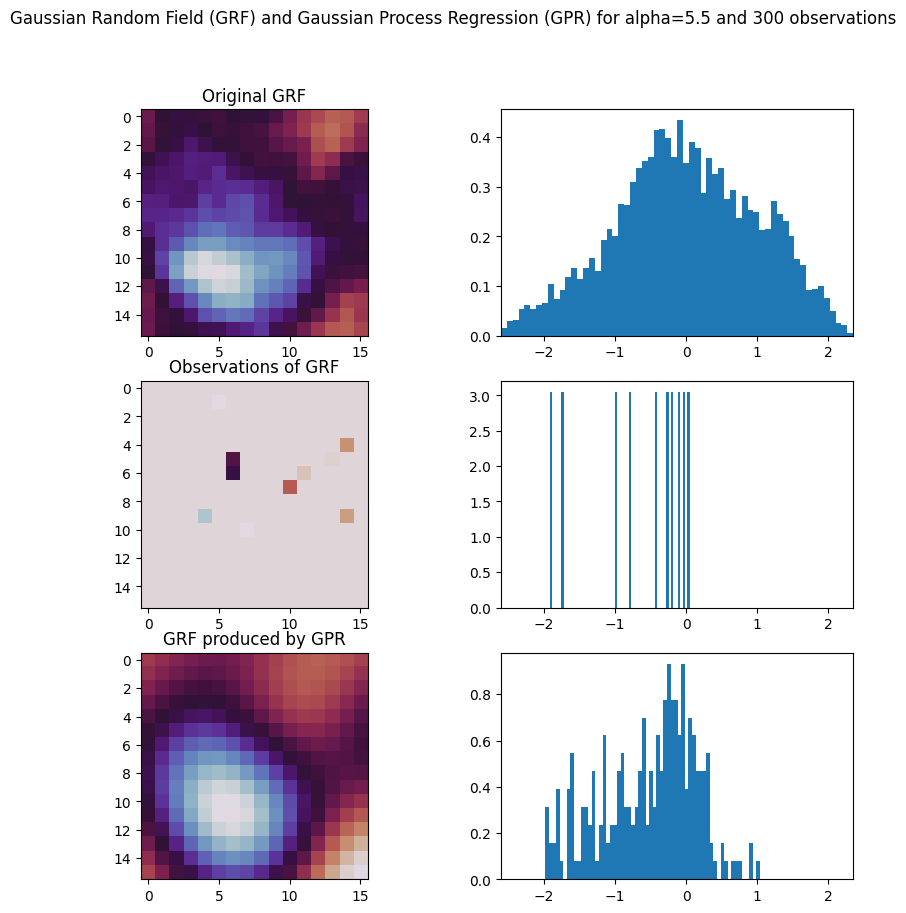

Alpha: 7.5, Constant Value: 2.6781022253988023, Beta: 2.25


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


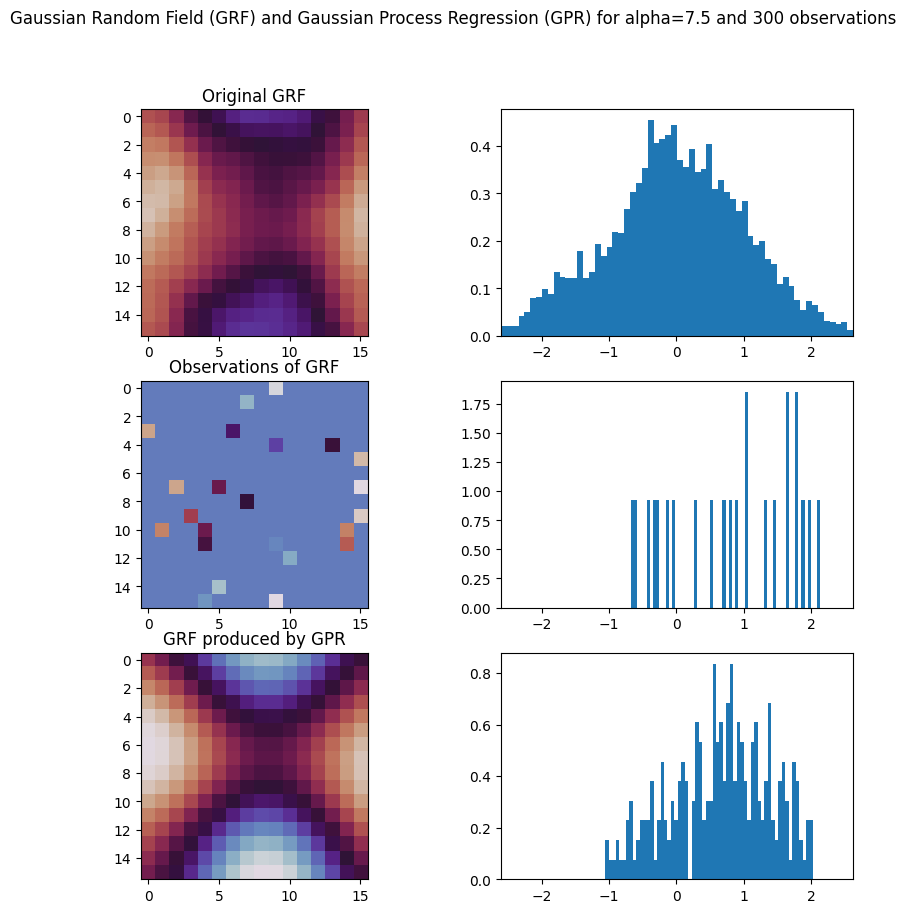

In [27]:
n_obs = 300

for alpha in [3.5, 4.5, 5.5, 7.5]:
    f = dft_GRF(n_cells=N, box_size=L, alpha=alpha)
    X_train, y_train = get_observations(f, n_obs=n_obs, n_cells=N, dim=dim)
    y_GPR = GRF_GPR(X_train, y_train, n_cells=N, dim=3, alpha=alpha)
    plot_results(f, X_train, y_GPR, alpha=alpha, n_obs=n_obs, n_cells=N, z_axis=N//2)

Alpha: 6.5, Constant Value: 3.670526967647336, Beta: 1.75


c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


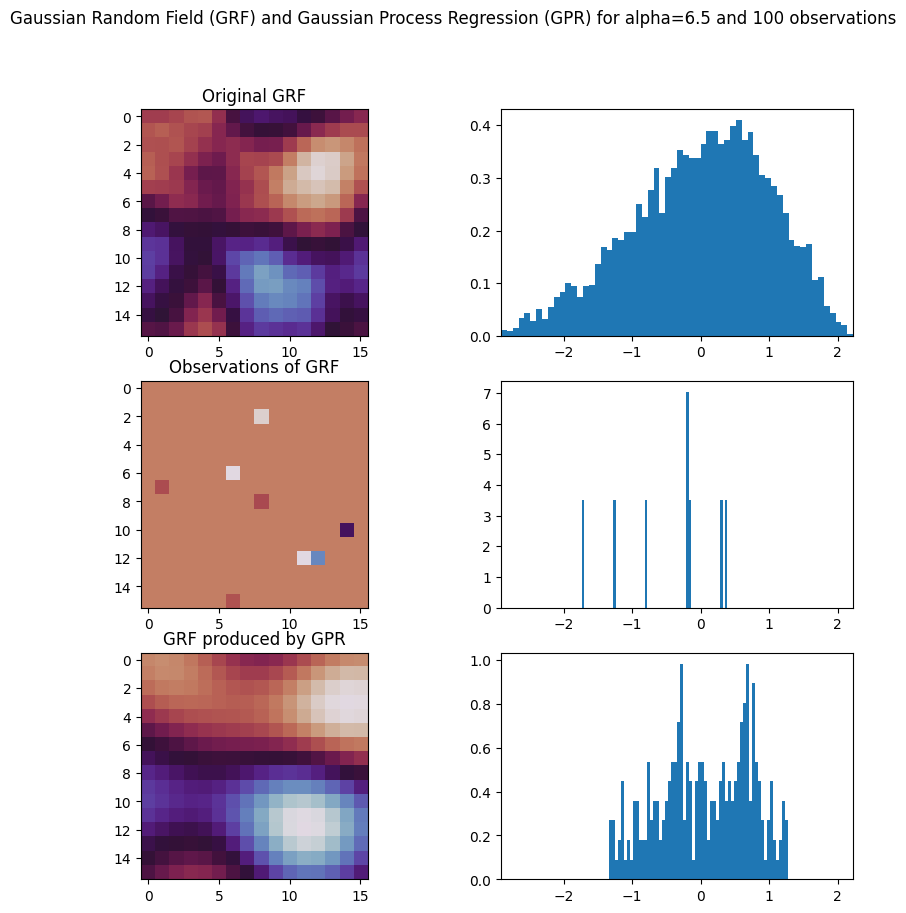

In [32]:
alpha = 6.5

for n_obs in [20, 100, 500, 1000]:
    f = dft_GRF(n_cells=N, box_size=L, alpha=alpha)
    X_train, y_train = get_observations(f, n_obs=n_obs, n_cells=N, dim=dim)
    y_GPR = GRF_GPR(X_train, y_train, n_cells=N, dim=3, alpha=alpha)
    plot_results(f, X_train, y_GPR, alpha=alpha, n_obs=n_obs, n_cells=N, z_axis=N//2)